# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Nesse modelo vamos passar a considerar os textos das íntegras.

A primeira passagem, serão criadas colunas com as palavras-chaves informadas pela área negocial que vão indicar a ausência ou presença do termo no texto da íntegra da peça de promoção do arquivamento.

Na segunda passagem, vamos passar a considerar unicamente o texto da íntegra.

**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados.

Vamos ler os textos das íntegras, limpá-los e associar ao dataframe com os dados de homologação.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"

In [4]:
# carga dos textos

from os import listdir
from os.path import isfile, join
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('portuguese')
stop_words.extend(['n', 'nº', 'n°', 'n.º', ',', '.', '!', '?', ';', ':', '...', 'º', '–', '/', '(', ')'])

def get_text(file):
    with open(file, encoding='utf-8', errors='replace') as f:
        data=' '.join(line.strip() for line in f)
        f.close()
    
    return data.strip()

def get_text_non_stop_words(text):
    filtered_text = ''
    for w in word_tokenize(text, language='portuguese'):
        if w not in stop_words:
            filtered_text += w
            filtered_text += ' '            
    return filtered_text.strip()   
    

folder_integras = f'{PATH}/integras-textos'

texts = {}
for file in listdir(folder_integras):
    if isfile(join(folder_integras, file)):
        texts[file.split('.')[0]] = get_text(join(folder_integras,file))
    else:
        print('is not file', file)



In [5]:
# montando um DataFrame
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')
df_work = df_original.copy()
cols = ['id', 'homologado']
df_work.drop(inplace=True, columns=[col for col in df_work.columns if col not in cols])
df_work['peca_promocao'] = None
df_work.sample(5)

,homologado,id,peca_promocao
7633,1,66517753,None
5497,1,72065811,None
1651,1,82088795,None
7730,1,63493951,None
8329,1,29962317,None


In [6]:
# Associando o texto...
for key, text in zip(texts.keys(), texts.values()):
    if key != '' and text != '':
        df_work.loc[df_work.id == int(key), 'peca_promocao'] = text
        
df_work.sample(5)

,homologado,id,peca_promocao
2275,1,82607016,PROMOÇÃO DE ARQUIVAMENTO Trata-se de proce...
6061,1,67691524,None
5014,1,29957346,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...
233,1,59315354,EXCELENTÍSSIMO JUIZ FEDERAL DA 1ª VARA DA SUBS...
2141,1,57176018,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...


In [7]:
print(len(df_work[df_work['homologado'] == 1]), len(df_work[df_work['homologado'] == 0]))

8267 134


In [8]:
# removendo os sem textos de peça de promoção (problema nos dados)
print(len(df_work[df_work['peca_promocao'].isnull()]))
df_work.dropna(subset=['peca_promocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)
print(len(df_work[df_work['peca_promocao'].isnull()]))

1688
0


In [9]:
print(len(df_work[df_work['homologado'] == 1]), len(df_work[df_work['homologado'] == 0]))

6612 101


In [10]:
#Carga das palavras chaves
palavras_chaves = pd.read_csv(f'{PATH}/1A.CAM.palavras-chaves.txt')
palavras_chaves

,palavras-chaves,expressao-regular
0,AUSÊNCIA DE IRREGULARIDADES,\bausência[s]?\b(\s)+\bde\b(\s)+\birregularida...
1,IRREGULARIDADE SANADA,\birregularidade[s]?\b(\s)+\bsanada[s]?\b
2,NÃO COMPROVAÇÃO,\bnão\b(\s)+\bcomprovação\b
3,INEXISTÊNCIA,\binexistência[s]?\b
4,SOLUCIONADA,\bsolucionada[s]?\b
5,EXAURIMENTO,\bexaurimento\b
6,EXAURIDA,\bexaurida[s]?\b
7,PERDA DE OBJETO,\bperda\b(\s)+\bde\b(\s)+\bobjeto\b
8,IRREGULARIDADE NÃO COMPROVADA,\birregularidade[s]?\b(\s)+\bnão\b(\s)+\bcompr...
9,INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE,\binexistência\b(\s)+\bde\b(\s)+\bindício[s]?\...


## Busca de palavras-chaves nos textos das peças de promoção

Dada a lista de palavras-chaves anteriormente listada, vamos procurá-la nos textos das íntegras.

Vamos criar uma coluna para cada uma das palavras-chaves e marcar com ausência ou presença da mesma no texto correspondente.

Vamos utilzar expressões regulares.

In [11]:
pcs = palavras_chaves['palavras-chaves']

# vou ignorar as colunas com o caractere '+' // PRECISAMOS TRATAR ISSO AINDA
for pc in pcs:
    if pc.rfind('+') == -1:
        df_work[pc.strip()] = 0

df_work.sample(5)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
6216,1,66963169,Procedimento Preparatório PR-RJ nº 1.30.001.00...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,1,78674245,PORTARIA DE INSTAURAÇÃO DE INQUÉRITO CIVIL PÚB...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3605,1,79225216,Procedimento Preparatório nº 1.11.000.000840/2...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6470,1,62426062,JUNTADA TUTELA COLETIVA – INQUÉRITO CIVIL N...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5519,1,71302150,"Av. Beira Mar, 1064, Praia Treze de Julho, Ara...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
import re


#print(df_work['peca_promocao'][0])
len(re.findall('xxxx', df_work['peca_promocao'][0]))

0

In [37]:
import re

for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        regex = re.compile(palavras_chaves['expressao-regular'][i], re.IGNORECASE)
        column = palavras_chaves['palavras-chaves'][i]
        for key in range(len(df_work)):
            n_present = len(re.findall(regex, df_work['peca_promocao'][key]))
            df_work.loc[key, column] = n_present
            #if re.search(regex, df_work['peca_promocao'][key]):
            #    df_work.loc[key, column] = 1
            
df_work.sample(10)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
5791,1,64962465,TOMADA DE CONTAS ESPECIAL Peças de Informação...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4077,1,73818503,MINISTÉRIO PÚBLICO FEDERAL Procuradoria da Rep...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
934,1,69316457,Inquérito Civil nº 1.14.000.001436/2018-11 Ar...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
358,1,58851040,OFÍCIO MPF/GAB/SJRP n AUTOS Nº 1.34.015.0004...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6049,1,68343617,Timbrado M INISTÉRIO PÚBLICO FEDERAL PROCU...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3768,1,63823685,Cabeçalho MINISTÉRIO PÚBLICO FEDERAL PROCU...,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2492,1,65388620,PR-AP-00025295/2017 MINISTÉRIO PÚBLICO FEDERA...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,1,86206899,NF 1.33.010.000135/2018-97 PROMOÇÃO DE ARQ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5513,1,64997903,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2225,1,65247781,______________________________________________...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Correlacionando as palavras-chaves com a homologação/não homologação

A ideia aqui é mostrar o percentual de presença/ausência de palavras chaves e suas relações com a variável dependente.

In [44]:
df_homologado = df_work[df_work['homologado'] == 1]
df_nao_homologado = df_work[df_work['homologado'] == 0]
len(df_homologado), len(df_nao_homologado)

(6612, 101)

In [64]:
df_result_pc = pd.DataFrame(columns=['Palavra-Chave', 'Total', '#Homologados', '#Não Homologados', '% Homologados'])

for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        column = str(palavras_chaves['palavras-chaves'][i])
        q_homologados = len(df_homologado[df_homologado[column] != 0])
        q_nhomologados = len(df_nao_homologado[df_nao_homologado[column] != 0])
        total = q_homologados + q_nhomologados
        percentual = 0
        if total != 0:
            percentual = (q_homologados/total)*100
        df_result_pc = df_result_pc.append({'Palavra-Chave': column, 'Total':total, 
                                            '#Homologados': q_homologados, '#Não Homologados': q_nhomologados, 
                                            '% Homologados':round(percentual,2)}, ignore_index=True)

df_result_pc

,Palavra-Chave,Total,#Homologados,#Não Homologados,% Homologados
0,AUSÊNCIA DE IRREGULARIDADES,426,420,6,98.59
1,IRREGULARIDADE SANADA,42,42,0,100.00
2,NÃO COMPROVAÇÃO,35,33,2,94.29
3,INEXISTÊNCIA,1118,1100,18,98.39
4,SOLUCIONADA,165,161,4,97.58
5,EXAURIMENTO,92,91,1,98.91
6,EXAURIDA,93,92,1,98.92
7,PERDA DE OBJETO,44,43,1,97.73
8,IRREGULARIDADE NÃO COMPROVADA,7,7,0,100.00
9,INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE,4,4,0,100.00


**IMPORTANTE**

Verificar os casos acima, de não homologados, em que há as palavras-chaves listadas:

- Perda de Objeto (*nesse caso, o procedimento foi enviado erroneamente para a 1A.CAM - era da 7A.CAM*)
- Correção de Falhas
- Não comprovação
- Direito Individual
- Ausência de Irregularidades (1.23.000.001516/2017-78)

Algumas palavras aparecem e uma quantidade significativa nas 2 classes. Exemplos: ADOTADAS e INEXISTENCIA. Talvez valha a pena treinar um modelo sem elas.

# Treinando um modelo com Random Forest

In [65]:
# vamos treinar o modelo
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((5034, 28), (1679, 28))

In [66]:
cols_to_remove = ['id', 'peca_promocao', 'homologado']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
model.score(train[features], train['homologado'])

0.9856972586412396

In [68]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

    
print_score()

Accuracy score: 0.9839189994044074
Precision score:  0.9839189994044074
Recall score:  1.0
F1 score:  0.9918943260282198


In [69]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 1652]])

### Treinando sem as palavras chaves INEXISTÊNCIA e ADOTADAS

In [70]:
cols_to_remove = ['id', 'peca_promocao', 'homologado', 'INEXISTÊNCIA', 'ADOTADAS']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9839189994044074
Precision score:  0.9839189994044074
Recall score:  1.0
F1 score:  0.9918943260282198


In [71]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 1652]])

### Analisando a presença de palavras-chaves em conjunto

A ideia é analisar o efeito não apenas das palavras-chave em isolamento, mas também da presença combinada delas.

In [72]:
'''
IDEIA: criar uma variável que representa a soma dos valores das palavra-chaves.
Em suma, vai indicar o número de palavras-chaves presentes no texto.
'''
#df_work['palavras_combinadas'] = 0
for row in range(len(df_work)):
    present = 0
    for k in range(len(palavras_chaves)):
        if palavras_chaves['palavras-chaves'][k].rfind('+') == -1:
            column = str(palavras_chaves['palavras-chaves'][k])
            if df_work.loc[row, column] == 1:
                present += 1
    df_work.loc[row, 'palavras_combinadas'] = present

df_work.sample(10)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN,palavras_combinadas
798,1,79767720,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2186,1,57237825,MM I NI S T É RI OI NI S T É RI O P P ÚB LI C...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
120,1,77063006,PRM-JAU-SP-00004451/2018 MINISTÉRIO PÚBLICO F...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
6478,1,62509666,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA RE...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3678,1,74714499,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0.0
3374,1,75361102,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3854,1,75520943,autos: 1.25.015.000142/2016-59 classe: procedi...,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1008,1,73285506,EXMA PRM-RVD-GO-00004460/2018 /2017 MINISTÉ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2029,1,55622062,IC nº 1.22.005.000167/2014-11 DECISÃO: Prom...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
5053,1,41290130,EXCELENTÍSSIMO (A) SENHOR (A) JUIZ (A) FEDERAL...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [73]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((5034, 29), (1679, 29))

In [74]:
cols_to_remove = ['id', 'peca_promocao', 'homologado']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [75]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9839189994044074
Precision score:  0.9839189994044074
Recall score:  1.0
F1 score:  0.9918943260282198


In [76]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 1652]])

### Feature Importance

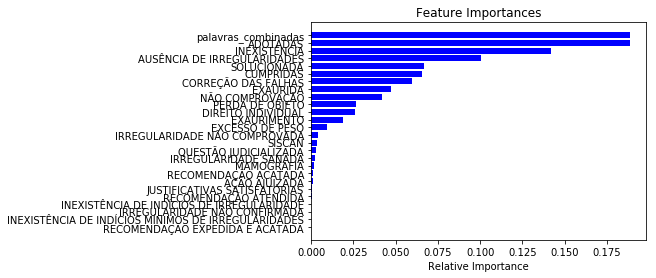

In [77]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

Vou retirar as *features* com importância menor que 5%.

In [78]:
important_features = []
indices = np.argsort(model.feature_importances_)
model.feature_importances_, indices

size = len(model.feature_importances_)
important_features = [features[i] for i in indices if i < size and model.feature_importances_[i] >= 0.05]

In [79]:
model = RandomForestClassifier(random_state=42, n_estimators=100)


model.fit(train[important_features], train['homologado'])
train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9839189994044074
Precision score:  0.9839189994044074
Recall score:  1.0
F1 score:  0.9918943260282198


In [80]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 1652]])

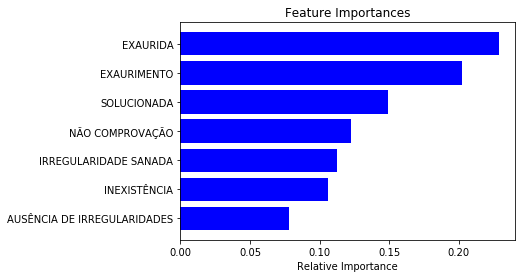

In [81]:
plot_fi(model.feature_importances_)

## Tentando com modelos lineares: LogisticRegression e Naive Bayes

In [86]:
from sklearn.linear_model import LogisticRegression

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

clf = LogisticRegression(random_state=42)

cols_to_remove = ['id', 'peca_promocao', 'homologado', 'palavras_combinadas']
features = [col for col in df_work.columns if col not in cols_to_remove]

clf.fit(train[features], train['homologado'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
train_preds = clf.predict(train[features])
valid_preds = clf.predict(valid[features])

print_score()

Accuracy score: 0.9839189994044074
Precision score:  0.9839189994044074
Recall score:  1.0
F1 score:  0.9918943260282198


In [88]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 1652]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

### Conclusão

O modelo com palavras-chaves não se mostrou muito bom. As palavras-chaves são bons indicadores, mas não são suficientes, por si só, para o treino de um modelo.

## Combinando as palavras-chaves com os outros metadados